# Movielens
Pada proyek ini saya membuat sistem rekomendasi content-based filtering dan collaborative filtering. Disini saya menggunakan Dataset Movielens. Dataset ini merupakan Dataset yang berisi 1.000.209 peringkat anonim dari sekitar 3.900 film
dibuat oleh 6.040 pengguna MovieLens yang bergabung dengan MovieLens pada tahun 2000. untuk lebih lengkapnya bisa dicek pada tautan dibawah ini:\
[MovieLens](https://www.kaggle.com/datasets/sherinclaudia/movielens)

## Download Dataset
Disini saya akan langsung melakukan download dari kaggle. dengan kode sebagai berikut:

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                           title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ruchi798/data-science-job-salaries                            Data Science Job Salaries                             7KB  2022-06-15 08:59:12          15228        485  1.0              
neelgajare/dogecoin-historical-price-data                     DogeCoin Historical Price Data                       34KB  2022-07-28 15:37:35            878         28  1.0              
himanshunakrani/student-study-hours                           Student Study Hours                                  276B  2022-07-20 13:17:29           1053         39  1.0              
saketpradhan/electric-and-alternative-fuel-charging-stations  Electric

In [ ]:
!kaggle datasets download -d sherinclaudia/movielens

 86% 5.00M/5.83M [00:00<00:00, 24.1MB/s]
100% 5.83M/5.83M [00:00<00:00, 27.7MB/s]


unzip file yang telah didownload

In [ ]:
!unzip movielens.zip -d /content/

Archive:  movielens.zip
  inflating: /content/movies.dat     
  inflating: /content/ratings.dat    
  inflating: /content/users.dat      


## Data Understanding
Pada tahap ini saya melakukan eksplorasi pada data untuk mendapatkan insight. disini saya hanya menggunakan library pandas untuk melakukannya.

In [6]:
import pandas as pd

In [7]:
movies_cols = ['MovieID','Title','Genres']
ratings_cols = ['UserID','MovieID','Rating','Timestamp']
users_cols = ['UserID','Gender','Age','Occupation','Zip-code']

karena data yang diterima dalam bentuk **.dat** jadi perlu ditambahkan beberapa parameter seperti `sep`dan `encoding` (kadang jika tidak diberikan akan muncul error). karena pada datasetnya tidak mengandung header maka perlu ditambahkan header pada parameternya.

In [8]:
movies=pd.read_csv('/content/movies.dat',sep='::',header=None,names=movies_cols, encoding='latin 1')
movies.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
ratings=pd.read_csv('/content/ratings.dat',sep='::',header=None,names=ratings_cols, encoding='latin 1')
ratings.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [10]:
users=pd.read_csv('/content/users.dat',sep='::',header=None,names=users_cols, encoding='latin 1')
users.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [11]:
print(f'Ukuran Data Movies : {movies.shape}')
print(f'Ukuran Data ratings : {ratings.shape}')
print(f'Ukuran Data users : {users.shape}')

Ukuran Data Movies : (3883, 3)
Ukuran Data ratings : (1000209, 4)
Ukuran Data users : (6040, 5)


In [12]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MovieID  3883 non-null   int64 
 1   Title    3883 non-null   object
 2   Genres   3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [13]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


Dari code diatas dapat diketahui ukuran data untuk **movies** adalah 3883 x 3 dan ratings adalah 1000209 x 4. ini ukuran data yang cukup besar. dan untuk mengetahui _unique_ pada masing-masing features rating, dapat menjalankan kode berikut:

In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   int64 
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   int64 
 3   Occupation  6040 non-null   int64 
 4   Zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


## Exploratory Data Analysis
### Univariate Exploratory Data Analysis
Pada proses ini saya akan mencari kode unik pada masing-masing fitur dengan menjalankan kode berikut:

In [15]:
 # Jumlah user
print('ratings dataset mempunyai', ratings['UserID'].nunique(), 'unique users')
# jumlah film
print('ratings dataset mempunyai', ratings['MovieID'].nunique(), 'unique movies')
# jumlah ratings
print('ratings dataset mempunyai', ratings['Rating'].nunique(), 'unique ratings')
# List dari unique ratings
print('unique ratings terdiri dari', sorted(ratings['Rating'].unique()))

ratings dataset mempunyai 6040 unique users
ratings dataset mempunyai 3706 unique movies
ratings dataset mempunyai 5 unique ratings
unique ratings terdiri dari [1, 2, 3, 4, 5]


In [16]:
print('jumlah kategori pada gender: ',len(users['Gender'].unique()))
print('kategori pada gender: ',users['Gender'].unique())

print('jumlah unik umur: ',len(users['Age'].unique()))
print('unik umur: ',sorted(users['Age'].unique()))

print('jumlah unik pekerjaan: ',len(users['Occupation'].unique()))
print('kategori pada Occupation: ',sorted(users['Occupation'].unique()))

jumlah kategori pada gender:  2
kategori pada gender:  ['F' 'M']
jumlah unik umur:  7
unik umur:  [1, 18, 25, 35, 45, 50, 56]
jumlah unik pekerjaan:  21
kategori pada Occupation:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]



Selanjutnya saya akan melakukan Explorasi lebih dalam mengenai dataset `movieslens`. Agar dataset tidak mengalami perubahan saat membuat sistem rekomendasi nanti, jadi saya mencopy datanya ke variabel lain. 

In [17]:
movies2 = movies.copy()
movies2.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Untuk kode dibawah ini, saya memunculkan seluruh kategori pada features `Genres` 

In [18]:
genre_labels = set()
for s in movies2['Genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))
print(len(genre_labels))
genre_labels

18


{'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

Fungsi ini akan mengitung jumlah film pada masing-masing kategori di features `Genres`

In [19]:
def countWord(dataset, ref_col, sensus):
    countKeywords = dict()
    for s in sensus: 
        countKeywords[s] = 0
    for sensus_keywords in dataset[ref_col].str.split('|'):        
        if type(sensus_keywords) == float and pd.isnull(sensus_keywords): 
            continue        
        for s in [s for s in sensus_keywords if s in sensus]: 
            if pd.notnull(s): 
                countKeywords[s] += 1
    keywordOccurences = []
    for k,v in countKeywords.items():
        keywordOccurences.append([k,v])
    keywordOccurences.sort(key = lambda x:x[1], reverse = True)
    return keywordOccurences, countKeywords

In [20]:
keyword_occurences, dum = countWord(movies2, 'Genres', genre_labels)
keyword_occurences

[['Drama', 1603],
 ['Comedy', 1200],
 ['Action', 503],
 ['Thriller', 492],
 ['Romance', 471],
 ['Horror', 343],
 ['Adventure', 283],
 ['Sci-Fi', 276],
 ["Children's", 251],
 ['Crime', 211],
 ['War', 143],
 ['Documentary', 127],
 ['Musical', 114],
 ['Mystery', 106],
 ['Animation', 105],
 ['Fantasy', 68],
 ['Western', 68],
 ['Film-Noir', 44]]

Dari kode diatas, dapat dianalisa bahwa banyak film dengan genre **Drama** dan **comedy** pada dataset ini.

### Bivariate Data Analysis
Sebelum menggunakan data untuk sistem rekomendasi. saya melakukan eksplorasi pada data terlebih dahulu. pertama-tama saya akan melakukan _merge_ pada dataset **movies**, **rating** dan users ke dalam variabel `merge_on_movieid`.

In [21]:
merge_on_movieid = pd.merge(movies,ratings,on = 'MovieID').reset_index(drop = True)
merge_on_movieid.head()

,MovieID,Title,Genres,UserID,Rating,Timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474


In [22]:
merge_on_userid = pd.merge(merge_on_movieid, users, on = 'UserID').reset_index(drop = True)
merge_on_userid.head()

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,1,10,48067
2,150,Apollo 13 (1995),Drama,1,5,978301777,F,1,10,48067
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4,978300760,F,1,10,48067
4,527,Schindler's List (1993),Drama|War,1,5,978824195,F,1,10,48067


karena pada proses EDA ini saya tidak membutuhkan fitur Genres,Timestamp dan Zip-code. maka saya akan membuang fitur tersebut

In [23]:
master_data = merge_on_userid.drop(['Genres','Timestamp','Zip-code'],axis = 1)
master_data.head()

,MovieID,Title,UserID,Rating,Gender,Age,Occupation
0,1,Toy Story (1995),1,5,F,1,10
1,48,Pocahontas (1995),1,5,F,1,10
2,150,Apollo 13 (1995),1,5,F,1,10
3,260,Star Wars: Episode IV - A New Hope (1977),1,4,F,1,10
4,527,Schindler's List (1993),1,5,F,1,10


selanjutnya saya melakukan eksplorasi dengan menggunakan representasi visual (grafik/plot) dengan menggunakan library matplotlib dan seaborn

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

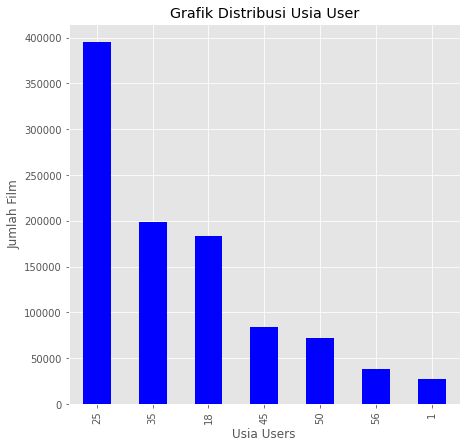

<Figure size 432x288 with 0 Axes>

In [25]:
# user age distribution
style.use('ggplot')
plt.figure(figsize = (7,7))
master_data['Age'].value_counts().plot(kind = 'bar', color = 'blue')
plt.xlabel('Usia Users')
plt.ylabel('Jumlah Film')
plt.title('Grafik Distribusi Usia User')
plt.show()
plt.savefig('plot1')

dari grafik tersebut dapat diketahui bahwa, kabanyakan penonton film pada dataset ini berada pada usia 25-34 tahun.

<Figure size 504x504 with 0 Axes>

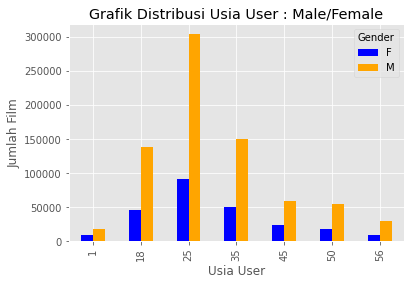

<Figure size 432x288 with 0 Axes>

In [26]:
# user age distribution
plt.figure(figsize = (7,7))
master_data.groupby('Age')['Gender'].value_counts().unstack().plot(kind = 'bar',color = ['blue','orange'])
plt.xlabel('Usia User')
plt.ylabel('Jumlah Film')
plt.title('Grafik Distribusi Usia User : Male/Female')
plt.show()
plt.savefig('plot2')

dari grafik diatas dapat diketahui bahwa mayoritas penonton film pada dataset ini merupakan laki-laki.

# Content-Based Filtering

Disini saya membuat sistem rekomendasi content-base filtering. Untuk membuat sistem rekomendasi ini saya akan menggunakan `movies` dataset. saya akan memanfaatkan features `Genres` pada dataset untuk mendapatkan rekomendasi.



### Data Preprocessing
**Mencari missing value**\
pada tahap ini saya megecek apakah ada missing value atau tidak

In [27]:
print(movies2.isna().sum())

MovieID    0
Title      0
Genres     0
dtype: int64


Bisa dilihat, tidak ada missing value pada dataset ini, jadi saya akan ke tahap selanjutnya.\



### Data Preparation
pada tahap ini, saya mengubah features `Genres` ke dalam bentuk **string array**

In [28]:
movies2['Genres'] = movies2.Genres.str.split('|')
movies2['Genres'] = movies2['Genres'].fillna("").astype('str')
movies2

,MovieID,Title,Genres
0,1,Toy Story (1995),"['Animation', ""Children's"", 'Comedy']"
1,2,Jumanji (1995),"['Adventure', ""Children's"", 'Fantasy']"
2,3,Grumpier Old Men (1995),"['Comedy', 'Romance']"
3,4,Waiting to Exhale (1995),"['Comedy', 'Drama']"
4,5,Father of the Bride Part II (1995),['Comedy']
...,...,...,...
3878,3948,Meet the Parents (2000),['Comedy']
3879,3949,Requiem for a Dream (2000),['Drama']
3880,3950,Tigerland (2000),['Drama']
3881,3951,Two Family House (2000),['Drama']


### Model Development
**TF-IDF Vectorizer**\
Pada tahap ini saya akan membuat sistem rekomendasi content-based filtering. saya membangun sistem rekomendasi ini berdasarkan _genre_ film. disini saya menggunakan TF-IDF Vectorizer untuk menemukan representasi fitur penting dari setiap kategori film. untuk melakukannya saya menggunakan fungsi `TfidfVectorizer` pada library sklearn.

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies2['Genres'])
tfidf_matrix.shape

(3883, 127)

**Similarity**\
Dalam menghitung drajat kesamaan (similarity degree) antar film, saya akan menggunakan `euclidean_distances` dari library sklearn.

In [30]:
from sklearn.metrics.pairwise import euclidean_distances
euclidean_dist = euclidean_distances(tfidf_matrix, tfidf_matrix)
euclidean_dist[:4, :4]

array([[0.        , 1.31001058, 1.34899327, 1.33744802],
       [1.31001058, 0.        , 1.41421356, 1.41421356],
       [1.34899327, 1.41421356, 0.        , 1.28686534],
       [1.33744802, 1.41421356, 1.28686534, 0.        ]])

Setelah menghitung kesamaan antar film. selanjutnya saya membuat fungsi `genre_recommendations` dengan satu parameter yaitu title(judul film yang ditonton). keluaran fungsi ini berupa rekomendasi film untuk pengguna sesuai genre film yang telah user tonton.

In [31]:
titles = movies2['Title']
genres = movies2['Genres']
indices = pd.Series(movies2.index, index=movies2['Title'])

def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(euclidean_dist[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    df = pd.DataFrame(titles.iloc[movie_indices])
    df['Genres'] = genres.iloc[movie_indices]
    return df

Selanjutnya saya akan mencoba sistem rekomendasi yang saya buat.

In [32]:
idx = 5
movies2['Title'][idx], movies2['Genres'][idx]
print('film yang telah ditonton user',movies2['Title'][idx],' genre: ', movies2['Genres'][idx])

recomendation_user = genre_recommendations(movies2['Title'][idx])
recomendation_user.head(10)

film yang telah ditonton user Heat (1995)  genre:  ['Action', 'Crime', 'Thriller']


,Title,Genres
4,Father of the Bride Part II (1995),['Comedy']
7,Tom and Huck (1995),"['Adventure', ""Children's""]"
10,"American President, The (1995)","['Comedy', 'Drama', 'Romance']"
11,Dracula: Dead and Loving It (1995),"['Comedy', 'Horror']"
12,Balto (1995),"['Animation', ""Children's""]"
13,Nixon (1995),['Drama']
16,Sense and Sensibility (1995),"['Drama', 'Romance']"
18,Ace Ventura: When Nature Calls (1995),['Comedy']
23,Powder (1995),"['Drama', 'Sci-Fi']"
24,Leaving Las Vegas (1995),"['Drama', 'Romance']"


dapat dilihat, sistem rekomendasi memunculkan 10 film. tapi dari 10 film tersebut terasa kurang meyakinkan dari genre nya. film yang telah ditonton user bergenre ['Action', 'Crime', 'Thriller'], sedangkan kebanyakan film yang direkomendasikan tidak sesuai. disini saya dapat memperbaikinya dengan mengganti metode similarity dengan menggunakan `cosine_similarity`. dan hasilnya didapatkan sebagai berikut :

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(3883, 3883)

In [34]:
titles = movies2['Title']
genres = movies2['Genres']
indices = pd.Series(movies2.index, index=movies2['Title'])

def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    df = pd.DataFrame(titles.iloc[movie_indices])
    df['Genres'] = genres.iloc[movie_indices]
    return df

In [35]:
idx = 5
movies2['Title'][idx], movies2['Genres'][idx]
print(movies2['Title'][idx], movies2['Genres'][idx])

recomendation_user = genre_recommendations(movies2['Title'][idx])
recomendation_user.head(10)

Heat (1995) ['Action', 'Crime', 'Thriller']


,Title,Genres
168,Hackers (1995),"['Action', 'Crime', 'Thriller']"
2209,Ronin (1998),"['Action', 'Crime', 'Thriller']"
2887,Someone to Watch Over Me (1987),"['Action', 'Crime', 'Thriller']"
3694,F/X (1986),"['Action', 'Crime', 'Thriller']"
3695,F/X 2 (1992),"['Action', 'Crime', 'Thriller']"
46,Seven (Se7en) (1995),"['Crime', 'Thriller']"
49,"Usual Suspects, The (1995)","['Crime', 'Thriller']"
517,Romeo Is Bleeding (1993),"['Crime', 'Thriller']"
653,Purple Noon (1960),"['Crime', 'Thriller']"
1073,Reservoir Dogs (1992),"['Crime', 'Thriller']"


dapat dilihat. Bahwa film-film yang direkomendasikan sekarang jauh lebih masuk akal dari pada tadi. 

# Collaborative Filtering
Pada tahap ini saya akan membuat sistem rekomendasi collaborative filtering. Disini saya akan memanfaatkan dataset **ratings**. Nantinya saya akan menggunakan keras pada framework tensorflow dalam membangun sistem rekomendasi ini. saya juga menggunakan library lain seperti numpy.

### Mencari Missing Value


In [36]:
print(ratings.isna().sum())
print(ratings.isnull().sum())

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64
UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64


dari kode diatas, dapat dilihat tidak ada _missing value_ atau nilai kosong pada data. sehingga saya langsung menuju ke tahap Data Preparation

## Data Preprocessing dan Preparation
pada tahap ini saya akan melakukan persiapan data sebelum data digunakan untuk melatih model. disini saya melakukan copy pada data ratings.

In [37]:
import numpy as np

In [38]:
ratings3 = ratings.copy()
ratings3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


Pada tahap Preprocessing, saya melakukan persiapan data dengan encode fitur `UserID` dan `MovieID`

In [39]:
user_ids = ratings3['UserID'].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
print(user2user_encoded)
print(userencoded2user)

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 47: 46, 48: 47, 49: 48, 50: 49, 51: 50, 52: 51, 53: 52, 54: 53, 55: 54, 56: 55, 57: 56, 58: 57, 59: 58, 60: 59, 61: 60, 62: 61, 63: 62, 64: 63, 65: 64, 66: 65, 67: 66, 68: 67, 69: 68, 70: 69, 71: 70, 72: 71, 73: 72, 74: 73, 75: 74, 76: 75, 77: 76, 78: 77, 79: 78, 80: 79, 81: 80, 82: 81, 83: 82, 84: 83, 85: 84, 86: 85, 87: 86, 88: 87, 89: 88, 90: 89, 91: 90, 92: 91, 93: 92, 94: 93, 95: 94, 96: 95, 97: 96, 98: 97, 99: 98, 100: 99, 101: 100, 102: 101, 103: 102, 104: 103, 105: 104, 106: 105, 107: 106, 108: 107, 109: 108, 110: 109, 111: 110, 112: 111, 113: 112, 114: 113, 115: 114, 116: 115, 117: 116, 118: 117, 119: 118, 120: 119, 121: 120, 122: 12

In [40]:
movie_ids = ratings3['MovieID'].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
print(movie2movie_encoded)
print(movie_encoded2movie)

{1193: 0, 661: 1, 914: 2, 3408: 3, 2355: 4, 1197: 5, 1287: 6, 2804: 7, 594: 8, 919: 9, 595: 10, 938: 11, 2398: 12, 2918: 13, 1035: 14, 2791: 15, 2687: 16, 2018: 17, 3105: 18, 2797: 19, 2321: 20, 720: 21, 1270: 22, 527: 23, 2340: 24, 48: 25, 1097: 26, 1721: 27, 1545: 28, 745: 29, 2294: 30, 3186: 31, 1566: 32, 588: 33, 1907: 34, 783: 35, 1836: 36, 1022: 37, 2762: 38, 150: 39, 1: 40, 1961: 41, 1962: 42, 2692: 43, 260: 44, 1028: 45, 1029: 46, 1207: 47, 2028: 48, 531: 49, 3114: 50, 608: 51, 1246: 52, 1357: 53, 3068: 54, 1537: 55, 647: 56, 2194: 57, 648: 58, 2268: 59, 2628: 60, 1103: 61, 2916: 62, 3468: 63, 1210: 64, 1792: 65, 1687: 66, 1213: 67, 3578: 68, 2881: 69, 3030: 70, 1217: 71, 434: 72, 2126: 73, 3107: 74, 3108: 75, 3035: 76, 1253: 77, 1610: 78, 292: 79, 2236: 80, 3071: 81, 902: 82, 368: 83, 1259: 84, 3147: 85, 1544: 86, 1293: 87, 1188: 88, 3255: 89, 3256: 90, 3257: 91, 110: 92, 2278: 93, 2490: 94, 1834: 95, 3471: 96, 589: 97, 1690: 98, 3654: 99, 2852: 100, 1945: 101, 982: 102, 1873:

Selanjutnya saya akan menggabungkan hasil encode tadi ke dalam dataset rating serta mengubah fitur `Rating` menjadi float.

In [41]:
# mapping UserID dan MovieID ke dataframe user dan movie
ratings3["user"] = ratings3["UserID"].map(user2user_encoded)
ratings3["movie"] = ratings3["MovieID"].map(movie2movie_encoded)
# Mengubah rating menjadi nilai float
ratings3['Rating'] = ratings3['Rating'].values.astype(np.float32)
ratings3.head()

,UserID,MovieID,Rating,Timestamp,user,movie
0,1,1193,5.0,978300760,0,0
1,1,661,3.0,978302109,0,1
2,1,914,3.0,978301968,0,2
3,1,3408,4.0,978300275,0,3
4,1,2355,5.0,978824291,0,4


Mengecek beberapa data seperti jumlah user, jumlah film, dan mengubah rating menjadi float

In [42]:
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)

min_rating = min(ratings3['Rating'])
max_rating = max(ratings3['Rating'])

print(f'Jumlah User: {num_users}, Jumlah Film: {num_movies}, Rating Minimum: {min_rating}, Rating maximuR: {max_rating}')

Jumlah User: 6040, Jumlah Film: 3706, Rating Minimum: 1.0, Rating maximuR: 5.0


### Pembagian Data untuk Data Training Dan Validasi
Pada tahap ini. saya akan membagi data saya menjadi data training dan validasi. disini saya menggunakan `train_test_split` pada library sklearn sehingga memudahkan saya dalam melakukannya. saya membagi data 80% training dan 20% testing.

In [43]:
from sklearn.model_selection import train_test_split

X = ratings3[['user', 'movie']].values
# Membuat variabel y dengan melakukan normalisasi pada data terlebih dahulu
y = ratings3['Rating'].apply(lambda X: (X - min_rating) / (max_rating - min_rating)).values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((800167, 2), (200042, 2), (800167,), (200042,))

### Modeling
Untuk model sistem rekomendasi collaborative filtering, model menghitung skor kecocokan antara pengguna dan movie dengan teknik embedding. Pertama, melakukan proses embedding terhadap data user dan movie. Selanjutnya, lakukan operasi perkalian dot product antara embedding user dan movie. Selain itu, saya juga dapat menambahkan bias untuk setiap user dan resto. Skor kecocokan ditetapkan dalam skala [0,1] dengan fungsi aktivasi sigmoid.

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [45]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
            mask_zero=True,
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
            mask_zero=True,
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

In [46]:
EMBEDDING_SIZE = 32
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Model ini menggunakan Binary Crossentropy untuk menghitung loss function, Adam (Adaptive Moment Estimation) sebagai optimizer, dan root mean squared error (RMSE) sebagai metrics evaluation. 
Langkah berikutnya, mulailah proses training. 

In [47]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 5,
    verbose=1,
    validation_data = (X_val, y_val)
)

Epoch 1/5
12503/12503 [==============================] - 42s 3ms/step - loss: 0.6190 - root_mean_squared_error: 0.2516 - val_loss: 0.6095 - val_root_mean_squared_error: 0.2431
Epoch 2/5
12503/12503 [==============================] - 36s 3ms/step - loss: 0.6128 - root_mean_squared_error: 0.2440 - val_loss: 0.6171 - val_root_mean_squared_error: 0.2480
Epoch 3/5
12503/12503 [==============================] - 37s 3ms/step - loss: 0.6211 - root_mean_squared_error: 0.2495 - val_loss: 0.6241 - val_root_mean_squared_error: 0.2524
Epoch 4/5
12503/12503 [==============================] - 44s 4ms/step - loss: 0.6279 - root_mean_squared_error: 0.2537 - val_loss: 0.6303 - val_root_mean_squared_error: 0.2565
Epoch 5/5
12503/12503 [==============================] - 38s 3ms/step - loss: 0.6348 - root_mean_squared_error: 0.2578 - val_loss: 0.6346 - val_root_mean_squared_error: 0.2590


### Visualisasi Metrik
Untuk melihat visualisasi matriks. saya menggunakan maplotlib untuk melakukannya.

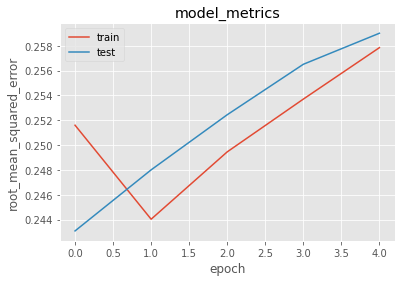

<Figure size 432x288 with 0 Axes>

In [48]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('plot3')

In [49]:
test_loss = model.evaluate(X_val, y_val)
print('\\nTest Loss: {}'.format(test_loss))

6252/6252 [==============================] - 14s 2ms/step - loss: 0.6161 - root_mean_squared_error: 0.2454
\nTest Loss: [0.6161371469497681, 0.24536041915416718]


Dari proses ini, saya memperoleh nilai accuracy akhir sebesar sekitar 0.61 dan val loss pada data sebesar 0.24. Nilai tersebut cukup bagus untuk sistem rekomendasi.

### Mendapatkan Rekomendasi
Untuk mendapatkan rekomendasi film, pertama saya mengambil sampel user secara acak dan definisikan variabel movies_not_visited yang merupakan daftar film yang belum pernah ditonton oleh user. variabel tersebutlah yang akan direkomendasikan ke user.\
Sebelumnya, user telah memberikan rating ke beberapa film. rating-rating itu akan digunakan untuk rekomendasi film yang mungkin cocok untuk user tersebut. dan film yang direkomendasikan tersebut merupakan film yang belum pernah ditonton oleh users.

In [56]:
print("Testing Model with 1 user")
movie_df = movies2
user_id = "new_user"
movies_watched_by_user = ratings3.sample(7)
# film yang belum pernah di lihat user
movies_not_watched = movie_df[~movie_df['MovieID'].isin(movies_watched_by_user.MovieID.values)]['MovieID'] 
movies_not_watched = list(
    set(movies_not_watched)
    .intersection(set(movie2movie_encoded.keys()))
)

movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

user_movie_array = np.hstack(([[0]] * len(movies_not_watched), movies_not_watched))


Testing Model with 1 user


Selanjutnya, saya menggunakan fungsi `model.predict()` untuk memberikan rekomendasi film kepada user sebanyak 5 film.

In [59]:
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]

recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Film-film yang diberi rating tinggi oleh user")
print("----" * 8)
top_movies_user = (movies_watched_by_user.sort_values(by="Rating", ascending=False).head(5).MovieID.values)
movie_df_rows = movie_df[movie_df["MovieID"].isin(top_movies_user)]
for i, row in enumerate(movie_df_rows.itertuples()):
    i += 1
    print(i,'.',row.Title, ":", row.Genres)

Showing recommendations for user: new_user
Film-film yang diberi rating tinggi oleh user
--------------------------------
1 . Like Water for Chocolate (Como agua para chocolate) (1992) : ['Drama', 'Romance']
2 . Fried Green Tomatoes (1991) : ['Drama']
3 . Meet Joe Black (1998) : ['Romance']
4 . Haunting, The (1999) : ['Horror', 'Thriller']
5 . Christmas Story, A (1983) : ['Comedy', 'Drama']


In [58]:
print("----" * 8)
print("10 rekomendasi film untuk user")
print("----" * 8)
recommended_movies = movie_df[movie_df["MovieID"].isin(recommended_movie_ids)]
for i, row in enumerate(recommended_movies.itertuples()):
    i+= 1
    print(i,'.',row.Title, ":", row.Genres)

--------------------------------
10 rekomendasi film untuk user
--------------------------------
1 . Star Wars: Episode IV - A New Hope (1977) : ['Action', 'Adventure', 'Fantasy', 'Sci-Fi']
2 . Schindler's List (1993) : ['Drama', 'War']
3 . Wallace & Gromit: The Best of Aardman Animation (1996) : ['Animation']
4 . Close Shave, A (1995) : ['Animation', 'Comedy', 'Thriller']
5 . Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963) : ['Sci-Fi', 'War']
6 . Godfather, The (1972) : ['Action', 'Crime', 'Drama']
7 . Wrong Trousers, The (1993) : ['Animation', 'Comedy']
8 . Third Man, The (1949) : ['Mystery', 'Thriller']
9 . 400 Blows, The (Les Quatre cents coups) (1959) : ['Drama']
10 . Stalag 17 (1953) : ['Drama', 'War']
